In [1]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Installing the required libraries
!pip install sentencepiece optuna
!pip install transformers datasets
!pip install torch huggingface_hub 
!pip install rouge.score nltk py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import nltk
import optuna

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Create function for printing 
def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

# Specify our parameter and project variables
# These parameter range can be changed with respect to amount of processing power available (GPU)
LR_MIN = 3e-5
LR_CEIL = 0.01
WD_MIN = 2e-5
WD_CEIL = 0.01
MIN_EPOCHS = 7
MAX_EPOCHS = 15
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.05
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
MODEL_NAME = 't5-small'
MAX_INPUT = 512
MAX_TARGET = 250

# Selecting the first 2000 rows just to see if the GPU issue doesnt recreate as the dataset is large
dataset_path = 'gdrive/My Drive/fyp/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:2000]

metric = datasets.load_metric('rouge')
data

<ipython-input-4-a776d12b2ee1>:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')


,document,summary
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...
...,...,...
1995,The former Aberconwy assembly member beat inde...,Conwy council has elected Plaid Cymru's Gareth...
1996,Variety says it will be based on the Iron Man ...,Robert Downey Jr is in talks to team up with T...
1997,I've always been suspicious of this sort of me...,Quite often management books look to the symph...
1998,The Scottish Fire and Rescue Service said more...,Firefighters battling the blaze at Glasgow Sch...


In [5]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

In [6]:
# Preprocessing the data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #get the document text
    
    inputs = [prefix + doc for doc in data_to_process["document"]]
  
    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

In [7]:
#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})

In [8]:
# Preprocess the data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [9]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(1000))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(300))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(200))
     
# Update the tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [10]:
#load model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# We are using batch_size to handle with the GPU limitation but if GPU size is not a limitation please use the recommend batch size from the hyperparameters
batch_size = 1

#data_collator to create batches. It preprocess data with the given tokenizer
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [11]:

# metrics
# compute rouge for evaluation 

def compute_rouge(pred):
    predictions, labels = pred
    #decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    #compute the average of the rouge scores
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [12]:
# Create the training arguments
args = transformers.Seq2SeqTrainingArguments(
    'generic-summary',
    evaluation_strategy='epoch',
    learning_rate=0.001,
    per_device_train_batch_size=1, # this is due to GPU limitation else per_device_train_batch_size should be used 
    per_device_eval_batch_size= 1, # this is due to GPU limitation else per_device_eval_batch_size should be used
    gradient_accumulation_steps=2,
    weight_decay=0.1,
    save_total_limit=2,
    warmup_ratio=0.1,
    num_train_epochs=9,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )
#only CUDA available -> fp16=True

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)


In [13]:
# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

In [14]:

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.369700,0.292683,27.720600,8.022100,22.500100,22.491000,18.726700
2,0.343400,0.224625,28.886000,9.038100,23.406300,23.342100,18.810000
3,0.274800,0.163171,34.697300,15.468200,29.208100,29.213000,18.626700
4,0.217800,0.116486,39.444000,21.077000,34.286300,34.331100,18.770000
5,0.171100,0.078957,45.042800,28.459200,40.289900,40.420300,18.756700
6,0.129900,0.049882,53.559200,40.398600,50.134200,50.114800,18.726700
7,0.097200,0.032154,60.781400,50.938400,58.569900,58.539800,18.806700
8,0.074600,0.021784,65.726000,58.207500,63.845300,63.856600,18.760000
9,0.059900,0.017955,69.057000,62.624300,67.594400,67.663700,18.790000


TrainOutput(global_step=4500, training_loss=0.3042493684556749, metrics={'train_runtime': 1491.3811, 'train_samples_per_second': 6.035, 'train_steps_per_second': 3.017, 'total_flos': 1218076213248000.0, 'train_loss': 0.3042493684556749, 'epoch': 9.0})

In [15]:
# Clearing the cuda memory
torch.cuda.empty_cache()

In [16]:
# Evaluate the model
metrics = trainer.evaluate()



Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.017954867333173752, 'eval_rouge1': 69.057, 'eval_rouge2': 62.6243, 'eval_rougeL': 67.5944, 'eval_rougeLsum': 67.6637, 'eval_gen_len': 18.79, 'eval_runtime': 75.613, 'eval_samples_per_second': 3.968, 'eval_steps_per_second': 3.968, 'epoch': 9.0}


Creating a line graph for the metrics
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

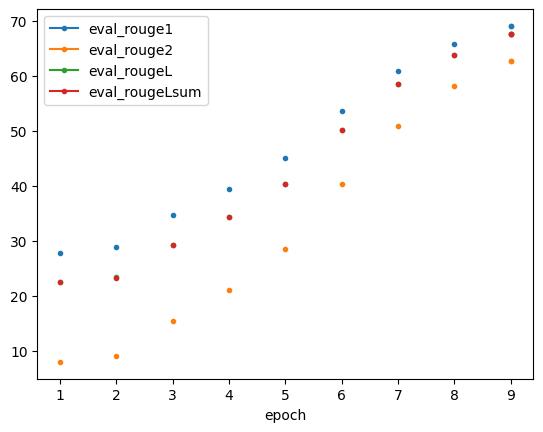

In [17]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('Creating a line graph for the metrics')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Creating the validation loss graph
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

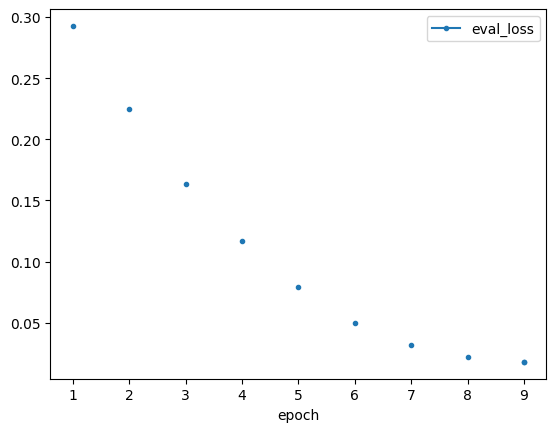

In [18]:
# Creating the validation loss graph 
print_custom('Creating the validation loss graph')
df.plot(x='epoch', y=['eval_loss'], style='.-')

<Axes: title={'center': 'Comparison of Training and Evaluation Losses by Epoch'}, xlabel='epoch'>

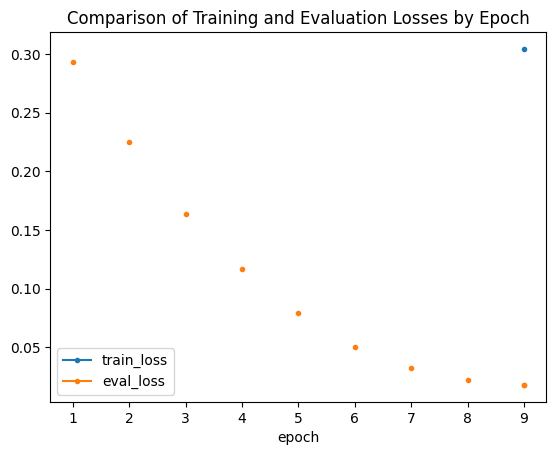

In [20]:
df.plot(x='epoch', y=['train_loss', 'eval_loss'], style='.-', title="Comparison of Training and Evaluation Losses by Epoch")


<Axes: title={'center': 'Learning Rate Schedule by Training Step'}, xlabel='step'>

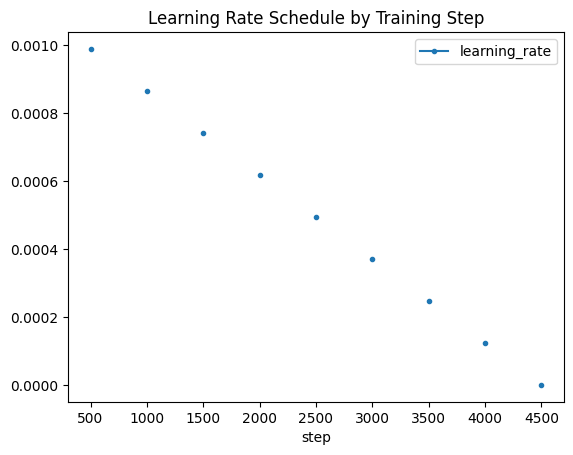

In [21]:
df.plot(x='step', y=['learning_rate'], style='.-', title="Learning Rate Schedule by Training Step")


In [ ]:
import os
import re

def capitalize_sentences(summary):
    # Capitalize the first letter of each sentence
    summary = re.sub(r'(?<=\.\s)(\w)', lambda x: x.group(1).upper(), summary)

    # Remove any leading punctuation or whitespace
    summary = re.sub(r'^[^a-zA-Z]*', '', summary)

    # Ensure the first character is uppercase
    summary = summary[0].upper() + summary[1:]

    return summary

document = """Russia has launched a series of missiles at Ukrainian cities in the second pre-dawn attack in three days.

Pavlohrad, a logistics hub near the central city of Dnipro, was hit ahead of a much-anticipated counter-offensive by Ukraine.

The strike sparked a major fire, destroyed dozens of houses, and wounded 34 people.

Hours later, the air raid alert sounded across the country, with the capital Kyiv among the targets.

Across the country, the Ukrainian army said it shot down 15 of the 18 cruise missiles that had been fired.

The most significant damage was in Pavlohrad, a city in Ukrainian-held territory around 70 miles (110km) from the frontline. Pictures posted on social media showed a massive blaze.

One resident, Olha Lytvynenko, said she was getting dressed to leave their house when "both doors were smashed out by the explosion wave".

"I ran outside and saw that the garage was destroyed. Everything was on fire, glass shards everywhere. Had we been outside, we would have been killed," she said.

Explosion derails train in Russian border region
Ukraine's Dnipropetrovsk military administration described it as a "tragic night and morning", saying an industrial site had been hit.

Nineteen high-rise apartment blocks, 25 private houses, six schools and kindergartens and five shops were also damaged, it added.

Vladimir Rogov, a Russian-installed official, said the strike targeted railway infrastructure and fuel depots, in a message on Telegram with a thumbs-up gesture.

At around 04:00 local time (02:00 GMT) the air raid alert sounded in Kyiv and lasted for about three hours.

The military administration said all missiles and drones directed at the capital were destroyed.

"""


inputs = tokenizer.encode(document, return_tensors='pt', max_length=MAX_INPUT, truncation=True)
outputs = model.generate(inputs, max_length=450, min_length=80, length_penalty=1.5, num_beams=4, early_stopping=True)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Capitalize the sentences in the summary
summary = capitalize_sentences(summary)

print("Generic summary")
print(summary)


In [ ]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-model'

# Ensure the model directory exists, and create it if not
model_directory = os.path.dirname(drive_path_to_save_model)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-tokenizer'

# Ensure the tokenizer directory exists, and create it if not
tokenizer_directory = os.path.dirname(drive_path_to_save_tokenizer)
if not os.path.exists(tokenizer_directory):
    os.makedirs(tokenizer_directory)

# Save the tokenizer
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

# Load the model
drive_path_to_load_model = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-model'
loaded_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(drive_path_to_load_model)

# Load the tokenizer
drive_path_to_load_tokenizer = 'gdrive/My Drive/fyp/GenericSummarizationModels/' + MODEL_NAME + '-tokenizer'
loaded_tokenizer = transformers.AutoTokenizer.from_pretrained(drive_path_to_load_tokenizer)